In [1]:
#@title Install dependencies
!git clone https://github.com/ComputBiophys/ProtRAP-LM.git
import torch
import numpy as np
import argparse,csv,sys
import os,requests
import torch.nn as nn
import torch.nn.functional as nnF
import os # 用于检测 Colab TPU 环境

# --- 设备检测 ---
device = None
device_type = None

if 'COLAB_TPU_ADDR' in os.environ and os.environ['COLAB_TPU_ADDR']:
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        device_type = "TPU"
        print("TPU detected. Using TPU.")
    except ImportError:
        print("TPU environment detected, but torch_xla is not installed.")
        print("Falling back to CPU/GPU check.")
if device is None:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_type = "GPU"
        print(f"GPU detected. Using {torch.cuda.get_device_name(0)}") # 显示 GPU 名称
    else:
        device = torch.device("cpu")
        device_type = "CPU"
        print("No TPU or GPU detected. Using CPU.")

model_path=lambda x:'ProtRAP-LM/models/model_'+str(x)+'.pts'
github_url=lambda x:f"https://github.com/ComputBiophys/ProtRAP-LM/releases/download/Version1.0/model_{str(x)}.pts"

def download_file(url, output_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(output_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded file from {url} to {output_path}")
    except Exception as e:
        print(f"Error downloading file: {e}, You may manually download this one")

for i in range(10):
    if not os.path.exists(model_path(i)):
        print('Downloading model_'+str(i))
        download_file(github_url(i), model_path(i))

def fasta_load(fasta_dir):
    fp = open(fasta_dir, 'r')
    lines = fp.readlines()
    fp.close()
    sequence = ''
    for line in lines[1:]:
        sequence = sequence + line.split()[0]
    return sequence
def weight_MSE_loss(labels,logits,weights=1):
    l=(labels-logits)**2
    l=l*weights
    return torch.sum(l)
def focal_loss_softmax(labels,logits):
    y_pred=logits
    l=-labels*torch.log(y_pred+1e-8)*((1-y_pred)**2)
    return torch.sum(l)

class MultiScaleCNN(nn.Module):
    def __init__(self,input_dim=1280,output_dim=256):#,size=[3,7,11],padding=[1,3,5]):
        super().__init__()
        self.cnn1=nn.Conv1d(input_dim,output_dim,3,padding=1)
        self.cnn2=nn.Conv1d(input_dim,output_dim,5,padding=2)
        self.cnn3=nn.Conv1d(input_dim,output_dim,7,padding=3)
        self.cnn4=nn.Conv1d(input_dim,output_dim,9,padding=4)
    def forward(self,x):
        x=x.permute(0,2,1)
        x1=self.cnn1(x)
        x2=self.cnn2(x)
        x3=self.cnn3(x)
        x4=self.cnn4(x)
        x=torch.cat((x1,x2,x3,x4), -2)
        x=x.permute(0,2,1)
        return x

class ProtRAP_LM():

    def __init__(self,device_name='cpu'):
        device = torch.device(device_name)
        self.device=device

        esm_model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
        batch_converter = alphabet.get_batch_converter()
        esm_model=esm_model.eval().to(device)
        models=[]
        for i in range(10):
            model=torch.jit.load(model_path(i)).to(device).eval()
            models.append(model)
        self.models=models
        self.esm_model=esm_model
        self.batch_converter=batch_converter

    def predict(self,seq):
        data=[('prot',seq)]
        _, _, batch_tokens = self.batch_converter(data)
        batch_tokens=batch_tokens.to(self.device)
        preds=[]
        with torch.no_grad():
            results=self.esm_model(batch_tokens,repr_layers=[33])
            Repr= results["representations"][33]
            for model in self.models:
                pred=model(Repr).to(torch.device("cpu"))
                preds.append(np.array(pred[0,1:-1,:]))
        preds=np.array(preds)
        mean_pred=np.mean(preds,axis=0)
        std_pred=np.std(preds,axis=0)
        result=np.concatenate((mean_pred,std_pred),axis=-1)
        return result
ProtRAP_LM_model=ProtRAP_LM(device)

Cloning into 'ProtRAP-LM'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 50 (delta 23), reused 47 (delta 21), pack-reused 1 (from 1)
Receiving objects: 100% (50/50), 24.04 KiB | 24.04 MiB/s, done.
Resolving deltas: 100% (23/23), done.
No TPU or GPU detected. Using CPU.
Downloaded file from https://github.com/ComputBiophys/ProtRAP-LM/releases/download/Version1.0/model_0.pts to ProtRAP-LM/models/model_0.pts
Downloaded file from https://github.com/ComputBiophys/ProtRAP-LM/releases/download/Version1.0/model_1.pts to ProtRAP-LM/models/model_1.pts
Downloaded file from https://github.com/ComputBiophys/ProtRAP-LM/releases/download/Version1.0/model_2.pts to ProtRAP-LM/models/model_2.pts
Downloaded file from https://github.com/ComputBiophys/ProtRAP-LM/releases/download/Version1.0/model_3.pts to ProtRAP-LM/models/model_3.pts
Downloaded file from https://github.com/ComputBiophys/ProtRAP-LM/relea

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [2]:
#@title Input


jobname = 'test' #@param {type:"string"}
#@markdown To avoid potential network issues, it is recommended to slice your too large fasta file into smaller portions before uploading.
sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
result_name=jobname+'.zip'
os.system(f"rm {result_name}")

256

In [3]:
#@title Run
result=ProtRAP_LM_model.predict(sequence)
np.savetxt(jobname+'_result.csv', result, delimiter=',')

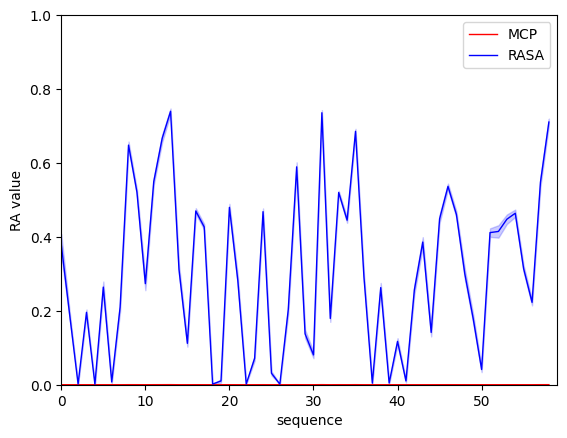

In [4]:
#@title Plots {run: "auto"}
import matplotlib.pyplot as plt

mean=result[:,:2]
std=result[:,2:]

y_lower= mean-std
y_upper = mean+std

x=np.arange(mean.shape[0])

plt.fill_between(x, y_lower[:,0], y_upper[:,0], color="red", alpha=0.2)
plt.plot(x,mean[:,0],color="red", linewidth=1,label ='MCP')

plt.fill_between(x, y_lower[:,1], y_upper[:,1], color="blue", alpha=0.2)
plt.plot(x,mean[:,1],color="blue", linewidth=1,label='RASA')
plt.ylim(0,1)
plt.xlim(0,mean.shape[0])
plt.xlabel('sequence')
plt.ylabel('RA value')
plt.legend()
plt.savefig(jobname+'_plot.png',dpi=300)

In [5]:
#@title Package and download results
from google.colab import drive,files
os.system(f"zip {result_name} {jobname}_*")
os.system(f"rm {jobname}_*")
files.download(f"{result_name}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>